<a href="https://colab.research.google.com/github/MashyBasker/research/blob/main/QML_6_qubit_circuit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
%pip install qiskit

In [ ]:
%%capture
%pip install pylatexenc
%pip install sklearn

In [ ]:
%matplotlib inline
import qiskit
from qiskit import QuantumCircuit, execute
import numpy as np
import matplotlib as mpl
from qiskit.circuit.library import UGate, CU3Gate
from qiskit import transpile, assemble
from qiskit import Aer, IBMQ
import pandas as pd
from qiskit.visualization import plot_histogram
from qiskit.providers.aer import AerSimulator
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import random

PI =  np.pi

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_url = '/content/drive/MyDrive/datasets/qnavigation/trainingData.csv'
valid_url = '/content/drive/MyDrive/datasets/qnavigation/validationData.csv'

train_data = pd.read_csv(train_url)
validation_data = pd.read_csv(valid_url)

In [ ]:
validation_data.shape

(1111, 529)

In [ ]:
train_data.drop(['FLOOR' , 'BUILDINGID' , 'SPACEID' , 'RELATIVEPOSITION' , 'USERID' , 'PHONEID' , 'TIMESTAMP'] , axis=1 , inplace=True)

In [ ]:
#count the number of missing values in dataset i.e 100
#not taking the features longittude, latitude for counting WAP missing values
avoid_feat = ['LONGITUDE' , 'LATITUDE']
feat_counts = {}
for feat, values in train_data.iteritems():
    if feat not in avoid_feat:
        feat_counts[feat] = train_data[feat].value_counts()[100]
print(feat_counts)

{'WAP001': 19919, 'WAP002': 19918, 'WAP003': 19937, 'WAP004': 19937, 'WAP005': 19897, 'WAP006': 19629, 'WAP007': 19359, 'WAP008': 19260, 'WAP009': 19342, 'WAP010': 19850, 'WAP011': 16981, 'WAP012': 16954, 'WAP013': 17962, 'WAP014': 17982, 'WAP015': 18930, 'WAP016': 18938, 'WAP017': 19853, 'WAP018': 19848, 'WAP019': 19519, 'WAP020': 19547, 'WAP021': 19900, 'WAP022': 19900, 'WAP023': 19156, 'WAP024': 19151, 'WAP025': 19306, 'WAP026': 19282, 'WAP027': 19156, 'WAP028': 19126, 'WAP029': 18413, 'WAP030': 18361, 'WAP031': 19328, 'WAP032': 19328, 'WAP033': 18371, 'WAP034': 18376, 'WAP035': 18057, 'WAP036': 18059, 'WAP037': 19073, 'WAP038': 19226, 'WAP039': 18432, 'WAP040': 18400, 'WAP041': 18205, 'WAP042': 18179, 'WAP043': 18736, 'WAP044': 18704, 'WAP045': 19183, 'WAP046': 19115, 'WAP047': 18505, 'WAP048': 18494, 'WAP049': 19538, 'WAP050': 19506, 'WAP051': 17719, 'WAP052': 17761, 'WAP053': 18886, 'WAP054': 18862, 'WAP055': 19906, 'WAP056': 19904, 'WAP057': 19421, 'WAP058': 19387, 'WAP059': 178

In [ ]:
#now we classify features according to the number of missing values
above_19 = {}
above_18 = {}
above_17 = {}
for k , v in feat_counts.items():
    if v >= 19000:
        above_19[k] = v
    elif v >= 18000 and v < 19000:
        above_18[k] = v
    elif v >= 17000 and v < 18000:
        above_17[k] = v

print(f"Above 19000: {len(above_19)}")
print(f"Above 18000: {len(above_18)}")
print(f"Above 17000: {len(above_17)}")

train_data.shape

Above 19000: 400
Above 18000: 62
Above 17000: 24


(19937, 522)

In [ ]:
#Dropping all of these features
for feat in feat_counts.keys():
    if feat in above_19.keys() or feat in above_18.keys() or feat in above_17.keys():
        train_data.drop(feat , axis=1 , inplace=True)

train_data.shape

(19937, 36)

In [ ]:
latitude_col = train_data['LATITUDE']
longitude_col = train_data['LONGITUDE']
final_train_data = train_data.drop(['LATITUDE', 'LONGITUDE'], axis=1) 
col_names = list(final_train_data)
print(col_names)

['WAP011', 'WAP012', 'WAP061', 'WAP062', 'WAP063', 'WAP064', 'WAP065', 'WAP066', 'WAP069', 'WAP070', 'WAP073', 'WAP074', 'WAP077', 'WAP078', 'WAP082', 'WAP083', 'WAP084', 'WAP085', 'WAP087', 'WAP117', 'WAP118', 'WAP121', 'WAP122', 'WAP131', 'WAP132', 'WAP144', 'WAP145', 'WAP248', 'WAP495', 'WAP496', 'WAP501', 'WAP502', 'WAP516', 'WAP517']


In [ ]:
for col in col_names:
    final_train_data[col] = np.array(final_train_data[col])
    final_train_data[col] = final_train_data[col] % PI

final_train_data

,WAP011,WAP012,WAP061,WAP062,WAP063,WAP064,WAP065,WAP066,WAP069,WAP070,...,WAP132,WAP144,WAP145,WAP248,WAP495,WAP496,WAP501,WAP502,WAP516,WAP517
0,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,...,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628
1,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,...,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628
2,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,...,2.610628,2.610628,2.610628,0.539816,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628
3,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,...,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628
4,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,...,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19932,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,...,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628
19933,2.610628,2.610628,1.106187,0.106187,2.610628,2.610628,1.247780,2.247780,3.106187,0.964594,...,2.247780,2.610628,2.610628,2.610628,2.610628,0.106187,2.610628,2.106187,2.610628,2.610628
19934,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,...,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628
19935,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,...,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628


[2.29754603 2.31192848 2.0187591  1.98714105 2.11648703 2.12093121
 2.02965481 1.98825517 2.17132924 2.07109073 2.22110821 2.18785432
 2.0467603  2.09461683 2.15352081 2.13179501 2.19208099 2.14932925
 1.86995111 2.30934263 2.27151182 2.28697895 2.28398441 2.23116348
 2.23692906 2.27138882 2.22606714 2.31468019 2.31900986 1.91905066
 2.30522233 1.99969187 2.3202494  2.01791892]
[2.56358188 2.56029366 2.59048594 2.58815447 2.59933902 2.59818751
 2.59503759 2.59674703 2.5644796  2.56540791 2.57785512 2.57903189
 2.57582178 2.57643795 2.5923897  2.58967852 2.58554333 2.58568109
 2.58047847 2.55226812 2.55396053 2.51932025 2.52071564 2.55290688
 2.55343774 2.56503871 2.55803194 2.44816923 2.53642041 2.58286724
 2.5198271  2.57667253 2.53499658 2.58088855]


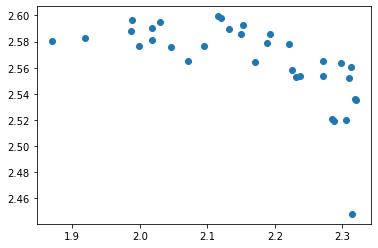

In [ ]:
kmeans = KMeans(n_clusters=2).fit(final_train_data)
prediction = list(kmeans.fit_predict(final_train_data))
centroid_0 = kmeans.cluster_centers_[0]
centroid_1 = kmeans.cluster_centers_[1]
one_index = []
zero_index = []
one_index, zero_index = [], []
for i in range(len(prediction)):
    if prediction[i] == 0:
        zero_index.append(i)
    elif prediction[i] == 1:
        one_index.append(i)
# print(len(one_index), prediction.count(1))
# print(len(zero_index), prediction.count(0))
print(centroid_0)
print(centroid_1)
plt.scatter(centroid_0, centroid_1)
plt.show()
# print(zero_index)
# print(one_index)

In [ ]:
classif_col = []
for i in range(19937):
    if i in zero_index:
        classif_col.append(0)
    elif i in one_index:
        classif_col.append(1)
print(classif_col)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 

In [ ]:
import itertools
def generate_comb_pairs(n):
    comb = []
    for i in range(n):
        comb += itertools.combinations(range(n),i+1)
    
    comb_list = [ list(t) for t in comb ]
    return comb_list

In [ ]:
print(generate_comb_pairs(2))

[[0], [1], [0, 1]]


In [ ]:
s=0
for i in range(4):
    s += 2 ** i
    print(s, end=", ")

1, 3, 7, 15, 

In [ ]:
def build_circuit(qc, n, theta):
    for i in range(n):
        t_list = list(range(i + 1))
        if i == 0:
            comb_pairs = generate_comb_pairs(i+1)
            t_list = list(range(i + 1))
            UG = UGate(theta[0], 0, 0)
            qc.append(UG, t_list)
        
        if i == 1:
            comb_pairs = generate_comb_pairs(i)
            CU3 = CU3Gate(theta[1], 0, 0)
            qc.append(CU3, t_list)

            CUG = CU3Gate(theta[2], 0, 0)
            qc.x(0)
            qc.append(CUG,t_list)
            qc.x(0)
            qc.barrier()

        if i > 1 and i < 5: 
            # starting point: 2 ^ 0 + 2 ^ 1 + ... + 2 ^ (i - 1)
            # ending point: starting point + (2 ^ i) - 1
            # i = 2 => m = 2 [3, 4, 5, 6]
            # i = 3 => m = 6 [7, 8, 9, 10 ... 14]
            # i = 4 => m = 14 [15, 16, 17 ... 30]
            # (m+1) .. (2 ^ i) + m
            comb_pairs = generate_comb_pairs(i)
            m = 0
            for x in range(i):
                m += 2 ** x
            UG = UGate(theta[m], 0, 0).control(i)
            qc.append(UG,t_list)
            for sublist in comb_pairs:
                for index in sublist:
                    qc.x(index)
                m += 1
                UG = UGate(theta[m], 0 , 0).control(i)
                qc.append(UG,t_list)
                for index1 in sublist:
                    qc.x(index1)
                qc.barrier()    
        elif i == 5:
            s = 0
            for x in range(i):
                s += 2 ** x
            comb_pairs = generate_comb_pairs(i)
            UG = UGate(theta[s], 0, 0).control(i)
            qc.append(UG, t_list)
            qc.x(0)
            s += 1
            UG = UGate(theta[s], 0, 0).control(i)
            qc.append(UG, t_list)
            qc.x(0)
            qc.x(1)
            s += 1
            UG = UGate(theta[s], 0, 0).control(i)
            qc.append(UG, t_list)
            qc.x(1)
            

        qc.barrier()
        qc.barrier()
    return qc

In [ ]:
def build_circuit_rev(qc, n, theta):
    for i in reversed(range(n)):
        t_list = list(range(i+1))
        if i == 0:
            comb_pairs = generate_comb_pairs(i+1)
            t_list = list(range(i+1))
            UG = UGate(-theta[0],0,0)
            qc.append(UG,t_list)
        if i == 1:
            comb_pairs = generate_comb_pairs(i)
            CU3 = CU3Gate(-theta[2], 0, 0)
            qc.x(0)
            qc.append(CU3, t_list)
            qc.x(0)
            CUG = CU3Gate(-theta[1], 0, 0)
            qc.append(CUG,t_list)
            qc.barrier()
        elif i > 1 and i < 5: 
            m = 0
            for x in range(i):
                m += 2 ** x
            end = m + (2**i) - 1
            comb_pairs = generate_comb_pairs(i)
            for sublist in reversed(comb_pairs):
                for index in reversed(sublist):
                    qc.x(index)
                UG= UGate(-theta[end],0,0).control(i)
                qc.append(UG,t_list)
                end -= 1
                for index1 in reversed(sublist):
                    qc.x(index1)
                qc.barrier()   
            UG= UGate(-theta[end], 0, 0).control(i)
            qc.append(UG,t_list)
        elif i == 5:
            comb_pairs = generate_comb_pairs(i)
            s = 33
            # qc.x(3)
            # UG = UGate(-theta[s], 0, 0).control(i)
            # qc.append(UG, t_list)
            # qc.x(3)
            # qc.x(2)
            # s -= 1
            # UG = UGate(-theta[s], 0, 0).control(i)
            # qc.append(UG, t_list)
            # qc.x(2)
            qc.x(1)
            # s -= 1
            UG = UGate(-theta[s], 0, 0).control(i)
            qc.append(UG, t_list)
            qc.x(1)
            qc.x(0)
            s -= 1
            UG = UGate(-theta[s], 0, 0).control(i)
            qc.append(UG, t_list)
            qc.x(0)
            s -= 1
            UG = UGate(-theta[s], 0, 0).control(i)
            qc.append(UG, t_list)

        
        qc.barrier()
        qc.barrier()
    return qc

In [ ]:
print(np.array(final_train_data.iloc[0 , :]))

[2.61062774 2.61062774 2.61062774 2.61062774 2.61062774 2.61062774
 2.61062774 2.61062774 2.61062774 2.61062774 2.61062774 2.61062774
 2.61062774 2.61062774 2.61062774 2.61062774 2.61062774 2.61062774
 2.61062774 2.61062774 2.61062774 2.61062774 2.61062774 2.61062774
 2.61062774 2.61062774 2.61062774 2.61062774 2.61062774 2.61062774
 2.61062774 2.61062774 2.61062774 2.61062774]


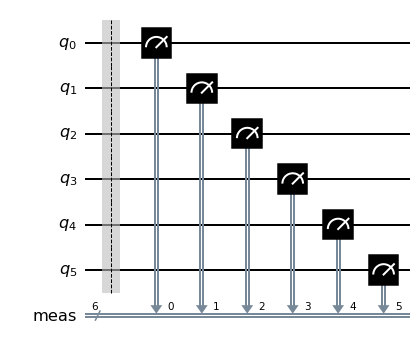

In [ ]:
qc = QuantumCircuit(6)
# qc = build_circuit(qc, 6, data)
# qc = build_circuit_rev(qc, 6, data)
# qc.x(0)
qc.measure_all()
qc.draw("mpl", style="bw")

In [ ]:
from qiskit.providers.aer import AerSimulator

def get_prob(n, qc):
    aer_sim = AerSimulator()
    t_qc = transpile(qc, aer_sim)
    qobj = assemble(t_qc, shots=10000)
    result = aer_sim.run(qobj).result()
    counts = result.get_counts()
    zeroes = '0'
    for i in range(n - 1):
        zeroes += '0'
    if zeroes in counts.keys():
        return counts[zeroes]/10000
    else:
        return 0

In [ ]:
print(get_prob(6, qc))

1.0


In [ ]:
def quantum_circuit(n, centroid, theta):
    qc = QuantumCircuit(6)
    qc = build_circuit(qc, 6, centroid)
    qc = build_circuit_rev(qc, 6, theta)
    qc.measure_all()
    return qc

In [ ]:
def H_Gate(qc, n):
    for j in range(n):
        qc.h(j)
    return qc

def var_circuit(n, layers, centroid, theta):
    qc = QuantumCircuit(6)
    for _ in range(layers):
        qc = H_Gate(qc, 6)
        qc = build_circuit(qc, 6, centroid)
    for _ in range(layers):
        qc = build_circuit_rev(qc, 6, theta)
        qc =  H_Gate(qc, 6)
    qc.measure_all()
    return qc

In [ ]:
def classifier(qc, n, layers):
    #layers = 0
    #n = 6
    theta = []
    classified = []
    classified = np.array(classified)
    theta = np.array(theta)

    for i in range(final_train_data.shape[0]):
        theta = np.array(final_train_data.iloc[i , :2000])
        qc_class_0 = quantum_circuit(n, centroid_0, theta)
        qc_class_1 = quantum_circuit(n, centroid_1, theta)
        # qc_covid = var_circuit(dim, layers, theta_covid, theta)
        # qc_normal = var_circuit(dim, layers, theta_normal, theta)
        probs = {0: np.sqrt(get_prob(n, qc_class_0)), 1: np.sqrt(get_prob(n, qc_class_1))}
        # print(directory+'/'+imgs[i])
        # print(probs)
        key_max = max(probs, key = probs.get)
        # print(key_max)
        classified = np.append(classified, key_max)
        print(classified)
    return classified

def get_accuracy(dim, layers, path):
    count = 0
    for i in range(len(classes)):
        if classes[i] == class_img:
            count += 1
    return (count/len(classes)) * 100

def model_accuracy(dim, layers):
    acc_covid = get_accuracy(dim, layers, covid_resized, 0)
    acc_normal = get_accuracy(dim, layers, normal_resized, 1)
    acc_pneu = get_accuracy(dim, layers, pneu_resized, 2)
    #print(acc_covid)
    #print(acc_normal)
    #print(acc_pneu)
    return (26/66 * (acc_covid) + 20/66 * (acc_normal) + 20/66 * (acc_pneu))

In [ ]:
"""
1. Make 2 columns: classical and quantum
2. quantum: getting from the circuit
3. classical: inner product from the centroid and data point; larger inner point goes into the column
"""

In [ ]:
def get_indexes(ndat, strtind):
    thetas = []
    classical_classified = []
    for i in range(strtind, len(zero_index)):
        if i == (ndat + strtind):
            break
        else:
            thetas.append(final_train_data.iloc[zero_index[i]])
            classical_classified.append(0)

    for i in range(strtind, len(one_index)):
        if i == (ndat + strtind):
            break
        else :
            thetas.append(final_train_data.iloc[one_index[i]])
            classical_classified.append(1)
    return thetas, classical_classified
# print(np.array(thetas))
# new_theta = np.concatenate(theta_0, theta_1)
# print(new_theta)
def quantum_classifier(qc, n, layers, new_theta):
    #layers = 0
    #n = 6
    classified = []
    classified = np.array(classified)
    for i in range(len(thetas)):
        qc_class_0 = quantum_circuit(n, centroid_0, thetas[i])
        qc_class_1 = quantum_circuit(n, centroid_1, thetas[i])
        # qc_covid = var_circuit(dim, layers, theta_covid, theta)
        # qc_normal = var_circuit(dim, layers, theta_normal, theta)
        probs = {0: np.sqrt(get_prob(n, qc_class_0)), 1: np.sqrt(get_prob(n, qc_class_1))}
        # print(directory+'/'+imgs[i])
        # print(probs)
        key_max = max(probs, key = probs.get)
        # print(key_max)
        classified = np.append(classified, key_max)
        print(classified)
    return classified

In [ ]:
val = quantum_classifier(qc, 6, 0, thetas)

In [ ]:
def check_accuracy(quantum_col, classica_col):
    yes = 0
    for i in range(len(quantum_col)):
        if quantum_col[i] == classica_col[i]:
            yes += 1
    return yes

In [ ]:
print(check_accuracy(val, classical_classified))

In [ ]:
def var_classifier(qc, n, layers, new_theta):
    #layers = 0
    #n = 6
    classified = []
    classified = np.array(classified)
    for i in range(len(new_theta)):
        qc_class_0 = var_circuit(n, layers, centroid_0, new_theta[i])
        qc_class_1 = var_circuit(n, layers, centroid_1, new_theta[i])
        # qc_covid = var_circuit(dim, layers, theta_covid, theta)
        # qc_normal = var_circuit(dim, layers, theta_normal, theta)
        probs = {0: np.sqrt(get_prob(n, qc_class_0)), 1: np.sqrt(get_prob(n, qc_class_1))}
        # print(directory+'/'+imgs[i])
        # print(probs)
        key_max = max(probs, key = probs.get)
        # print(key_max)
        classified = np.append(classified, key_max)
        # print(classified)
    return classified

In [ ]:
classical_classified

[0, 0, 0, 0, 0, 1, 1, 1, 1, 1]

In [ ]:
ans = var_classifier(qc, 6, 1, thetas)

In [ ]:
a, b = get_indexes(5)


In [ ]:
def accuracy_vs_data(ndat, i):
    # ndat = 5
    accuracy = []
    # data_pts = []
    for layers in range(1, 6):
        thetas, classical = get_indexes(ndat, i)
        var_class_list = var_classifier(qc, 6, layers, thetas)
        acc = check_accuracy(var_class_list, classical)
        accuracy.append(acc)
        # data_pts.append(ndat)
        print(acc)

    return accuracy, ndat

#1 , 6 , 11 , 16 , 21 

In [ ]:
acc, dpts = accuracy_vs_data(5)
print(acc)

In [ ]:
acc1, dpts1 = accuracy_vs_data(5)

In [ ]:
print(acc1)

[70.0]


In [ ]:
#for odd layers
datapt_5 = [90.0, 60.0, 80.0, 70.0, 70.0]
            #1    #3    #5    #7    #9

In [ ]:
#for even layers
acc2, dpts2 = accuracy_vs_data(5)

90.0
70.0
90.0
70.0
80.0


In [ ]:
print(acc2, dpts2)

[90.0, 70.0, 90.0, 70.0, 80.0] [5, 5, 5, 5, 5]


In [ ]:
def accuracy_vs_data_layer(ndat, layers):
    # ndat = 5
    accuracy = []
    # data_pts = []
    thetas, classical = get_indexes(ndat)
    var_class_list = var_classifier(qc, 6, layers, thetas)
    acc = check_accuracy(var_class_list, classical)
    accuracy.append(acc)
    # data_pts.append(ndat)
    print(acc)

    return accuracy, ndat



In [ ]:
acc, dpt = accuracy_vs_data(5, 21)

8
10
5
9
9


In [ ]:
"""
            10dp             20dp               30dp                40dp                50dp
layer 1     9   --(+9)-->    18  --(+9)-->      27      --(+8)-->   35      --(+8)-->   43
layer 2     9   --(+10)-->   19  --(+9)-->      28      --(+9)-->   37      --(+10)-->  47
layer 3     6   --(+7)-->    13  --(+8)-->      21      --(+7)-->   28      --(+5)-->   33
layer 4     7   --(+9)-->    16  --(+7)-->      23      --(+9)-->   32      --(+9)-->   41
layer 5     8   --(+8)-->    16  --(+6)-->      22      --(+9)-->   31      --(+9)-->   40
-------------------------------------------------------------------------------------------
Average:    78%              82%                80.666%              81.5%              81.6% 
"""

print(acc)
# print(dpt)

[8, 9, 7, 9, 9]


In [ ]:
def euclid(A, B):
    """Returns the euclidean distance for an n-dimensional plane"""
    vec_diff = A - B
    sqr = vec_diff ** 2
    euc_dist = np.sqrt(np.sum(sqr))
    return euc_dist


In [ ]:
q = np.array([1, 2])
w = np.array([3, 4])
sq_sum = (q - w) ** 2
euc = np.sqrt(np.sum(sq_sum))
euc

2.8284271247461903

In [ ]:
size = len(centroid_0)
origin = np.zeros(size)

In [ ]:
cent0dst = euclid(origin, centroid_0)
cent1dst = euclid(origin, centroid_1)
cent0dst, cent1dst

(12.622431590668038, 14.959176928548057)

In [ ]:
final_train_data

,WAP011,WAP012,WAP061,WAP062,WAP063,WAP064,WAP065,WAP066,WAP069,WAP070,...,WAP132,WAP144,WAP145,WAP248,WAP495,WAP496,WAP501,WAP502,WAP516,WAP517
0,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,...,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628
1,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,...,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628
2,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,...,2.610628,2.610628,2.610628,0.539816,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628
3,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,...,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628
4,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,...,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19932,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,...,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628
19933,2.610628,2.610628,1.106187,0.106187,2.610628,2.610628,1.247780,2.247780,3.106187,0.964594,...,2.247780,2.610628,2.610628,2.610628,2.610628,0.106187,2.610628,2.106187,2.610628,2.610628
19934,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,...,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628
19935,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,...,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628,2.610628


In [ ]:
euclid_dist = []
for i in range(19937):
    row = np.array(final_train_data.loc[i, :].values.flatten())
    euc = euclid(row, origin)
    euclid_dist.append(euc)

[15.222444759804173, 15.222444759804173, 15.006626834695046, 15.222444759804173, 15.222444759804173, 15.222444759804173, 15.012387068395594, 15.222444759804173, 15.222444759804173, 14.997355803733244, 15.09087749198172, 15.222444759804173, 15.222444759804173, 15.222444759804173, 15.222444759804173, 15.222444759804173, 15.222444759804173, 14.998961364345293, 15.164430765442466, 15.222444759804173, 14.997290520102483, 15.222444759804173, 15.222444759804173, 14.998961364345293, 15.027903694119098, 15.222444759804173, 15.12504803432858, 15.107308902641234, 15.222444759804173, 15.222444759804173, 15.037655962701228, 15.222444759804173, 15.222444759804173, 15.222444759804173, 15.222444759804173, 15.222444759804173, 15.222444759804173, 15.222444759804173, 15.222444759804173, 15.222444759804173, 15.222444759804173, 15.222444759804173, 15.222444759804173, 15.222444759804173, 15.222444759804173, 14.998961364345293, 14.006538339665253, 11.805621546544154, 15.222444759804173, 14.628739989514546, 1

In [ ]:
clust0, clust1 = [], []
for d in euclid_dist:
    if abs(d - cent0dst) > abs(d - cent1dst):
        clust0.append(d)
    elif abs(d - cent0dst) < abs(d - cent1dst):
        clust1.append(d)

print(clust1)

[11.805621546544154, 13.034628534886087, 12.764213191644458, 13.5564450104577, 13.696127990400882, 13.028786508862504, 13.233908587896023, 13.456682043007957, 13.725246607725175, 13.46691622979236, 13.055580737243428, 13.20228054169359, 13.276037123616229, 13.529260492004898, 13.645251205534336, 13.429652347550922, 13.16390125968598, 12.776710732619673, 12.738558633229891, 13.464524981175492, 13.509332927458479, 13.72138823633964, 13.233099666293882, 13.71689143664557, 12.247146433126328, 12.600517281602619, 13.357923203548355, 13.396331960536587, 13.19496463668332, 13.027503285292385, 12.803159844313194, 13.20723027180932, 12.87420465802354, 13.159564821351315, 13.570690842988306, 13.138313793700517, 13.277564667464905, 13.056321795763605, 13.36031320380418, 13.660186864441274, 12.5064373307014, 13.240424720924109, 12.925238663586116, 13.16326088634996, 13.331699400588663, 13.081366691163685, 13.15290835272763, 13.694895317748841, 13.560365198549835, 13.669751096337462, 13.46817364916